In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import torchvision

from PIL import Image,ImageOps
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm


In [2]:
class SigDataset_train(Dataset):

    def __init__(self , path,transforms=None):

        

        self.path = path
        
        self.transform=transforms



    def __getitem__(self , idx):
        person_id = int(idx % 128) + 1 #since total number of authors are 160 and i am using 1- 128 for training
        sample = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))# for Randomly picking a signature
              
        org_img_name = 'H-S-'+ str(person_id) + '-G-' + sample + '.tif' #original signature image name
        org_img_path = os.path.join(self.path , str(person_id),org_img_name)
        org_img = Image.open(org_img_path).convert('L') # Inputing the image using PIL and converting it to grey scale
        img0=ImageOps.invert(org_img)#inverting the image so that signature of white in colour on a black background
        


        label = int(np.random.randint(low = 0 , high = 2 , size = 1)) # selecting the second image.
                                                                      # if 0 pick one original image.
                                                                      # if 1 pick a forged image.



        if label == 1:
            # Picking forged image #
            sample1 = str(int(np.random.randint(low = 1 , high = 31 , size = 1)))
            forg_img_name = 'H-S-'+ str(person_id) + '-F-' + sample1 + '.tif'
            forg_img_path = os.path.join(self.path ,str(person_id) ,forg_img_name)
            forg_img = Image.open(forg_img_path).convert('L')
            img1 = ImageOps.invert(forg_img)

        else:
            # Picking real image #
            sample2 = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))
            sim_img_name = 'H-S-'+ str(person_id) + '-G-' + sample2 + '.tif'
            sim_img_path = os.path.join(self.path ,str(person_id) ,sim_img_name)
            sim_img = Image.open(sim_img_path).convert('L')
            img1 = ImageOps.invert(sim_img)
            
        if self.transform is not None:
            img0=self.transform(img0)#will be used to resize the image and convert it into tensor
            img1=self.transform(img1)
        return img0,img1,torch.from_numpy(np.array([int(label)],dtype=np.float32))

            

            

    def __len__(self):
        # since there are 128 authors and each have 24 original signature

        return 128*24

In [3]:
class SigDataset_test(Dataset):

    def __init__(self , path,transforms=None):

        # Setting the original and forge paths #

        self.path = path
        
        self.transform=transforms



    def __getitem__(self , idx):
        person_id = int(idx % 32) + 129 #since total number of authors are 160 of which 129-160 we are using for testing
        sample = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))# for Randomly picking a signature
              
        org_img_name = 'H-S-'+ str(person_id) + '-G-' + sample + '.tif' #original signature image name
        org_img_path = os.path.join(self.path , str(person_id),org_img_name)
        org_img = Image.open(org_img_path).convert('L') # Inputing the image using PIL and converting it to grey scale
        img0=ImageOps.invert(org_img)#inverting the image so that signature of white in colour on a black background
        

         # selecting the second image.
        label = int(np.random.randint(low = 0 , high = 2 , size = 1))
                                                                      # if 0 pick one original image.
                                                                      # if 1 pick a forged image.



        if label == 1:
            # Picking forged image #
            sample1 = str(int(np.random.randint(low = 1 , high = 31 , size = 1)))
            forg_img_name = 'H-S-'+ str(person_id) + '-F-' + sample1 + '.tif'
            forg_img_path = os.path.join(self.path ,str(person_id) ,forg_img_name)
            forg_img = Image.open(forg_img_path).convert('L')
            img1 = ImageOps.invert(forg_img)

        else:
            # Picking real image #
            sample2 = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))
            sim_img_name = 'H-S-'+ str(person_id) + '-G-' + sample2 + '.tif'
            sim_img_path = os.path.join(self.path ,str(person_id) ,sim_img_name)
            sim_img = Image.open(sim_img_path).convert('L')
            img1 = ImageOps.invert(sim_img)
            
        if self.transform is not None:
            img0=self.transform(img0)
            img1=self.transform(img1)
        return img0,img1,torch.from_numpy(np.array([int(label)],dtype=np.float32))

            

            

    def __len__(self):
        # since there are 32 authors in out test set and each ahs 24 original signature 

        return 32*24

In [4]:
#load the train dataset from raw image folders
train_dataset=SigDataset_train(r"/kaggle/input/bhsig260-hindi/BHSig260-Hindi",
                               transforms=transforms.Compose([transforms.Resize((300,300)),transforms.ToTensor()]))

In [5]:
# defining the model architecture

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=9, stride=1, padding=4),  
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2), 
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),  
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),   
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  
            nn.MaxPool2d(kernel_size=2, stride=2),                 
            nn.ReLU(inplace=True),
        )
        self.flatten=nn.Flatten()

        # Decoder
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),   
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),    
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),   
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),  
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),  
            nn.Upsample(scale_factor=1.045, mode='bicubic')  #to mkae the image dimention 300x300
        )
        self.Sim1=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1296,324),
            nn.ReLU(),
            
            nn.Linear(324,256),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            
            nn.Linear(256,128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            
            nn.Linear(128,64),
            
        )
        
        
        
        

    def forward(self, x,y):
        # x is the first image and y is the image it is compared to
        x = self.encoder(x)
        encoding_x=self.Sim1(self.flatten(x))
        x = self.decoder(x)
        
        y = self.encoder(y)
        encoding_y=self.Sim1(self.flatten(y))
        y = self.decoder(y)
        
        return x,y,encoding_x,encoding_y


class SimNet(nn.Module):
    def __init__(self):
        super(SimNet, self).__init__()
        
        self.Simaese=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(64,32),
            nn.Linear(32,16),
            nn.Dropout(p=0.5),
            nn.Linear(16,1),
            nn.Sigmoid()
        )
        
    def forward(self,x_encoding,y_encoding):
        diff=x_encoding-y_encoding
        out=self.Simaese(diff)
        
        return out



In [6]:
# # Example usage
# model = AutoEncoder()
# model2=SimNet()

# dummy_input_x = torch.randn(1, 1, 300, 300)  # Example input shape (batch_size, channels, height, width)
# dummy_input_y = torch.randn(1, 1, 300, 300)  # Example input shape (batch_size, channels, height, width)
# output = model(dummy_input_x,dummy_input_y)
# out=model2(output[2],output[3])
# print(output[0].shape,output[1].shape,output[2].shape,output[3].shape)

# # print("Output shape:", output.shape)  # Check the final output shape


In [7]:
# print(out)

In [8]:
# defining loss function 
# it is a combination of reconstructive loss of the autoencoder and classification loss for the image pair
class RanaKaGhata(torch.nn.Module):
    

    def __init__(self, beta=1.0,lambda_l2=1e-5):
        super(RanaKaGhata, self).__init__() 
        self.beta=beta
        self.lambda_l2=lambda_l2
        

    def forward(self,x_orig,y_orig,x_predict,y_predict,sim,label,model_1,model_2):
        base_loss=self.beta*(F.l1_loss(x_orig,x_predict)+F.l1_loss(y_orig,y_predict))+F.binary_cross_entropy(sim,label)
        l2_loss=0
        for param in model_1.parameters():
            l2_loss += torch.sum(param.pow(2))
        for param in model_2.parameters():
            l2_loss += torch.sum(param.pow(2))
        total_loss=base_loss+self.lambda_l2*l2_loss
        
        return total_loss

In [9]:
# function to check the accuracy of the model
def check_accuracy(model_1,model_2,dataloader,batch_size=128,datasplit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net_1=model_1
    net_2=model_2

    net_1.eval()
    net_1.eval()
    count=0
    correct=0
    incorrect=0
    for i, data in enumerate(dataloader,0): 
      
  
      x, y , label = data
      label=label.to(device)
  

      output_x,output_y,encoding_x,encoding_y = model_1(x.to(device),y.to(device))
      prob_forged=model_2(encoding_x,encoding_y)
      predicted_label=prob_forged>0.5
      predicted_label=predicted_label.to(device)
      correct_prediction=torch.sum(predicted_label==label)
      correct+=correct_prediction
      incorrect+=(batch_size-correct_prediction)
    if datasplit is not None:
        print(f"the accuracy on {datasplit} data is {(correct)/(correct+incorrect)} ")
    else:
         print(f"the accuracy  is {(correct)/(correct+incorrect)} ")
        

/tmp/ipykernel_24/2682337449.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))# for Randomly picking a signature
/tmp/ipykernel_24/2682337449.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(np.random.randint(low = 0 , high = 2 , size = 1)) # selecting the second image.
/tmp/ipykernel_24/2682337449.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample1 = str(int(np.random.

0.8573825359344482
0.7837045788764954
0.7697741389274597
0.7694457173347473
0.7666014432907104
Epoch 1
 Current loss 0.7893816828727722

0.7687183618545532
0.7580142021179199
0.7506350874900818
0.7503160834312439
0.7762767672538757
Epoch 2
 Current loss 0.7607921004295349

0.7233070135116577
0.7332537174224854
0.7442395091056824
0.7367328405380249
0.717529833316803
Epoch 3
 Current loss 0.7310125827789307

0.7612476348876953
0.7332717180252075
0.6911291480064392
0.7507902979850769
0.7562478184700012
Epoch 4
 Current loss 0.738537323474884

0.6920214891433716
0.666950523853302
0.7099829316139221
0.691887378692627
0.7053150534629822
Epoch 5
 Current loss 0.6932314753532409

the accuracy on test data is 0.66796875 
0.7177795767784119
0.6779161095619202
0.6241999864578247
0.5600513815879822
0.6291500926017761
Epoch 6
 Current loss 0.641819429397583

0.5855602025985718
0.6574175357818604
0.5366244912147522
0.6844483613967896
0.5960546135902405
Epoch 7
 Current loss 0.6120210409164428

0.545

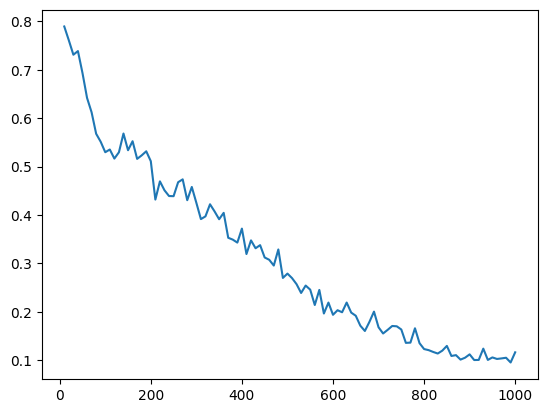

Models Saved Successfully


In [10]:
#loading training data

train_dataset=SigDataset_train(r"/kaggle/input/bhsig260-hindi/BHSig260-Hindi",
                               transforms=transforms.Compose([transforms.Resize((300,300)),transforms.ToTensor()]))

train_dataloader=DataLoader(train_dataset,shuffle=True,batch_size=64,drop_last=True)
#loading testing data
test_dataset=SigDataset_test(r"/kaggle/input/bhsig260-hindi/BHSig260-Hindi",
                               transforms=transforms.Compose([transforms.Resize((300,300)),transforms.ToTensor()]))
test_dataloader=DataLoader(test_dataset,shuffle=True,batch_size=32,drop_last=True)
# Declaring Auto-Siamese Network
net_1= AutoEncoder().cuda()
net_2=SimNet().cuda()
net_1.train()
net_2.train()
# Decalre Loss Function
criterion = RanaKaGhata()
# Declare Optimizer
optimizer_1 = torch.optim.Adam(net_1.parameters(), lr=1e-3)
optimizer_2 = torch.optim.Adam(net_2.parameters(), lr=1e-4 )
# setup learning rate scheduler
scheduler_1=CosineAnnealingLR(optimizer_1,T_max=45)
scheduler_2=CosineAnnealingLR(optimizer_2,T_max=45)

#defining the traing loop
def train(epochs=100):
    loss=[] #stores the average loss for each epoch
    counter=[]#created for loss plot
    iteration_number = 0
    for epoch in range(1,epochs+1):
        loss_temp=[]
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()
            output_x,output_y,encoding_x,encoding_y = net_1(img0,img1)
            sim=net_2(encoding_x,encoding_y)
            loss_test = criterion(img0,img1,output_x,output_y,sim,label,net_1,net_2)
            
            if (i%10)==0:
                print(loss_test.item())#prints loss every 10 batches
                loss_temp.append(loss_test.item())#used for average loss computation during an epoch
                
            loss_test.backward()
            optimizer_1.step()   
            optimizer_2.step()   
            scheduler_1.step()
            scheduler_2.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,np.mean(loss_temp)))#prints average loss during the epoch
        iteration_number += 10
        counter.append(iteration_number)
        
        loss.append(np.mean(loss_temp))
        if epoch%5==0:#after every 5 epochs checks the model performance on the test dataset
            # helps to determine when does the model starts to overfit
                check_accuracy(net_1,net_2,test_dataloader,batch_size=32,datasplit='test')

    plt.plot(counter, loss)   
    plt.show()
    return net_1,net_2


#set the device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1,model_2 = train()
# saves the model
torch.save(model_1.state_dict(), "auto_siamese-model_1_state_dicts.pt")
torch.save(model_2.state_dict(), "auto_siamese-model_2_state_dicts.pt")
print("Models Saved Successfully") 


In [11]:
# check the models performance on training data
check_accuracy(model_1,model_2,train_dataloader,batch_size=64,datasplit='train')



/tmp/ipykernel_24/2682337449.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))# for Randomly picking a signature
/tmp/ipykernel_24/2682337449.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(np.random.randint(low = 0 , high = 2 , size = 1)) # selecting the second image.
/tmp/ipykernel_24/2682337449.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample2 = str(int(np.random.

the accuracy on train data is 0.994140625 
